Project: Write a Data Science Blog Post

# Section 1: Business understanding
In this notebook an analysis of the 2016 Airbnb data for Seattle is performed. The analysis is done following the CRISP-DM process.

- Question 1: How is the price of available listings developing over time?
- Question 2: Which variables are incluencing the price of available listings?
- Question 3: Is it possible to predict the price of new listings?


# Section 2: Gather Data and Data understanding
First of all, the needed libs are imported. 
Additionally we load the Airbnb Seattle data into pandas dataframes in order to easy access and explore them througout the analysis.
By using the head() function of pandas dataframes we get a first feeling how the data look like.

In [1]:
# Import needed libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Load Airbnb data into dataframe
df_calendar = pd.read_csv('./Seattle/calendar.csv')
df_listings = pd.read_csv('./Seattle/listings.csv')
#df_reviews = pd.read_csv('./Seattle/reviews.csv')

# Show head to get a feeling of the data
#df_calendar.head()
#df_listings.head()
#df_reviews.head()

# Section 3: Prepare & Clean Data
In order to answer the first question the data from the calendar dataframe are prepared.
Therefore empty cells are filled, dates and price columns are converted to float and the listings are filtered to get only the available ones.

When the available listings are known and all columns are prepared, the mean value is calculated per month.

In [2]:
# Prepare calendar data in order to answer first question: How is the price development for listings in Seattle over the months?

# Price column contains NaN values for unavailable listings. Fill them with 0.
df_calendar['price'].fillna(0, inplace=True)

# Date column is a string value. Convert them to Python datetime for easy access via dt
df_calendar['date'] = pd.to_datetime(df_calendar['date'])

# Create new columns for year, month, day
df_calendar['year'] = df_calendar['date'].dt.year
df_calendar['month'] = df_calendar['date'].dt.month
df_calendar['day'] = df_calendar['date'].dt.day

# Remove "$" from price column and convert it to float
df_calendar['price'].replace('\$|,','', regex=True, inplace=True)
df_calendar['price'] = df_calendar['price'].astype('float')

# Filter only for available listings
df_available_listings = df_calendar[df_calendar['available'] == 't']

We will now do the cleaning of the listings dataframe. This data is needed for answering business question number 2 & 3.

The upcoming cells are preparing the listings dataframe columns. This dataframe shall be used to determine the variables (columns) which influence the price of available listings most. Before this determination can be done, pre-processing is necessary.

1. All rows with NaN values in the price column are dropped since this column shall be analysed.
2. Drop all cells containing any URL values since these will not have an impact on the price at all.
3. Multiple columns contain an price value as string. These columns need to be converted to float.
4. Also columns containing an "rate" (also a string) and "dates" (another string) need to be converted to float.


In [3]:
# Start with preparing the data for the next business questions: Which factors influence the price of listings?
# We will use the listings data for this

# Drop rows with missing price since we want to predict this feature
df_listings.dropna(subset=['price'], inplace=True)

# Drop any URL related column since they will not have any impact on the price
url_list = ['listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url','host_thumbnail_url', 
            'host_picture_url']
df_listings = df_listings.drop(url_list, axis=1)

# Convert dollar to float
df_listings['price'].replace('\$|,','', regex=True, inplace=True)
df_listings['price'] = df_listings['price'].astype('float')

df_listings['security_deposit'].replace('\$|,','', regex=True, inplace=True)
df_listings['security_deposit'] = df_listings['security_deposit'].astype('float')

df_listings['cleaning_fee'].replace('\$|,','', regex=True, inplace=True)
df_listings['cleaning_fee'] = df_listings['cleaning_fee'].astype('float')

df_listings['extra_people'].replace('\$|,','', regex=True, inplace=True)
df_listings['extra_people'] = df_listings['extra_people'].astype('float')

df_listings['monthly_price'].replace('\$|,','', regex=True, inplace=True)
df_listings['monthly_price'] = df_listings['monthly_price'].astype('float')

df_listings['weekly_price'].replace('\$|,','', regex=True, inplace=True)
df_listings['weekly_price'] = df_listings['weekly_price'].astype('float')

# Convert percent to float
df_listings['host_response_rate'].replace('\%|,','', regex=True, inplace=True)
df_listings['host_response_rate'] = df_listings['host_response_rate'].astype('float')

df_listings['host_acceptance_rate'].replace('\%|,','', regex=True, inplace=True)
df_listings['host_acceptance_rate'] = df_listings['host_acceptance_rate'].astype('float')

# Convert date to float
df_listings['host_since'].replace('\-|,','', regex=True, inplace=True)
df_listings['host_since'] = df_listings['host_since'].astype('float')
df_listings['last_scraped'].replace('\-|,','', regex=True, inplace=True)
df_listings['last_scraped'] = df_listings['last_scraped'].astype('float')
df_listings['first_review'].replace('\-|,','', regex=True, inplace=True)
df_listings['first_review'] = df_listings['first_review'].astype('float')
df_listings['last_review'].replace('\-|,','', regex=True, inplace=True)
df_listings['last_review'] = df_listings['last_review'].astype('float')   

Next we need to prepare columns containing lists. These lists are split into unique values. We define a matrix representing every row of the original dataframe and one column for every unique value. Afterwards we check the original lists about the presence of the unique values. For every present unique value the corresponding column and row get a 1 inserted otherwise it stays 0. In this way we create dummy variables representing the lists.

6. Columns directly describing the size of the listings are dropped since only relationships to not obvious values shall be found.
7. Create dummy values for categorical columns using pd.get_dummies function 
8. Join all created dummy dataframes with the original dataframe
9. Calculate the correlation of all columns with the price column and remove columns with a small correlation in order to reduce complexity.
10. Plot the result in order to determine the columns with a high correlation to price also in a visual way.

In [4]:
# Split amenities
all_ame = []
for x in df_listings.amenities:
    all_ame.extend(x.replace('{','')
                    .replace('}','')
                    .replace('"','')
                    .replace(' ','_')
                    .replace(',',' ')
                    .split()
                    )
unique_ame = pd.unique(all_ame)

# Create matrix with length of df_listings & column names according to split amenities
zero_matrix = np.zeros((len(df_listings),len(unique_ame)))
dummies_ame = pd.DataFrame(zero_matrix,columns=unique_ame)

# Fill the matrix based on availability of amenities within a listing
for i,ame in enumerate(df_listings.amenities):
    indices = dummies_ame.columns.get_indexer(ame.replace('{','').replace('}','').replace('"','').split(','))
    dummies_ame.iloc[i,indices]=1

# Split host_verifications
all_host_vers = []
for x in df_listings.host_verifications:
    all_host_vers.extend(x.replace('{','')
                      .replace('}','')
                      .replace('"','')
                      .replace(' ','_')
                      .replace(',',' ')
                      .split()
                    )
unique_host_vers = pd.unique(all_host_vers)

# Create matrix with length of df_listings & column names according to split amenities
zero_matrix = np.zeros((len(df_listings),len(unique_host_vers)))
dummies_host_vers = pd.DataFrame(zero_matrix, columns=unique_host_vers)

# Fill the matrix based on availability of amenities within a listing
for i,host_vers in enumerate(df_listings.host_verifications):
    indices = dummies_host_vers.columns.get_indexer(host_vers.replace('{','').replace('}','').replace('"','').split(','))
    dummies_host_vers.iloc[i,indices]=1

Columns which are directly influence the size of a listing are dropped since they have a obvious connection to the price.

In [5]:
remove_cols = ['bedrooms','beds','square_feet','bathrooms','weekly_price','monthly_price', 'cleaning_fee', 'amenities', 'host_verifications']
df_listings.drop(remove_cols, axis=1, inplace=True)

Last but not least we take care about columns containing categorical values. For simplicity reasons we remove columns with less than 3 unique values as also columns with more than 100 unique categorical values. After this filtering we create dummie variables for every column using pandas powerful get_dummies method. 

In [6]:
# Handle categorical values by creating dummies
df_list_cat = df_listings.select_dtypes(include=['object'])
cat_cols = df_list_cat.columns

# Remove columns with more than 100 unique values and also columns with less than 5 unique value
for col in cat_cols:   
    unique_vals = df_list_cat[col].nunique()

    if(unique_vals < 100 and unique_vals >= 3):
        df_list_cat = pd.concat([df_list_cat.drop(col, axis=1), pd.get_dummies(df_list_cat[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)
    else:
        df_list_cat.drop(col, axis=1, inplace=True)

c:\Users\EL6JCL5\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Section 4: Analyze Data
Next step is the calculation of the variables we are interested in. For answering the first business question this is the average price of the available listings per month.

In [7]:
#Calculate avg price per month for available listings
arr_avg_price_month = []
for month in range(1,13):
    arr_avg_price_month.append(df_available_listings[df_available_listings['month'] == month]['price'].mean())

For the second business question we calculate the correlation between the pre-selected columns and the price column. For simplicity reasons weak correlations are removed.

In [8]:
# Join the dummies and the original dataframe
df_listings = df_listings.join(df_list_cat)
df_listings = df_listings.join(dummies_ame)
df_listings = df_listings.join(dummies_host_vers)

# Calculate the correlation and drop columns which are weak correlated to price
weak_cols = df_listings.corr().columns[(np.abs(df_listings.corr()['price']) < 0.1)]
df_listings.drop(weak_cols, axis=1, inplace=True)

# Section 5: Data Modeling

Last step: Since now all columns with high correlation to the price column (the one we want to predict) are known, we can set up our Linear Regression model and train it.
- We select all numeric columns and fill missing values by the mean.
- We split the dataframe into a matrix containing only the values influencing the price and a vector containing the "result" of our prediciton (the price).
- We split our data into a test dataset, a train dataset and we initialize a linear regression model.
- Now the model is trained based on the train dataset
- Evaulate the results by calculating the R2-Score and the mean squared error for both train and test dataset in order to see the accuracy of our model as well as the fact if it is overfitted. 

In [9]:
# Filter the dataframe for numeric columns
df_list_numeric = df_listings.select_dtypes(include=['number'])
most_missing_cols = df_list_numeric.columns[df_list_numeric.isnull().mean() > .5]
df_list_numeric.drop(most_missing_cols, axis = 1, inplace=True)

# Impute missing values by mean
fill_mean = lambda x: x.fillna(x.mean())
df_list_numeric = df_list_numeric.apply(fill_mean, axis=0)

# Split into X and y
y = df_list_numeric['price']
X = df_list_numeric.drop('price', axis=1)

# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

# Initialize Linear Regression model
my_LR_model = LinearRegression(normalize=True)

# Train the model
my_LR_model.fit(X_train, y_train)

# Use the model in order to predict the price for our test dataset
y_test_pred = my_LR_model.predict(X_test)

# Use the model in order to predict the price for our train dataset (e.g. for seeing if the model is overfitted)
y_train_pred = my_LR_model.predict(X_train)

# Section 6: Visualize Data and Evaluation
Let's first of all print the price of available listings over time in order to answer business questions Nr. 1

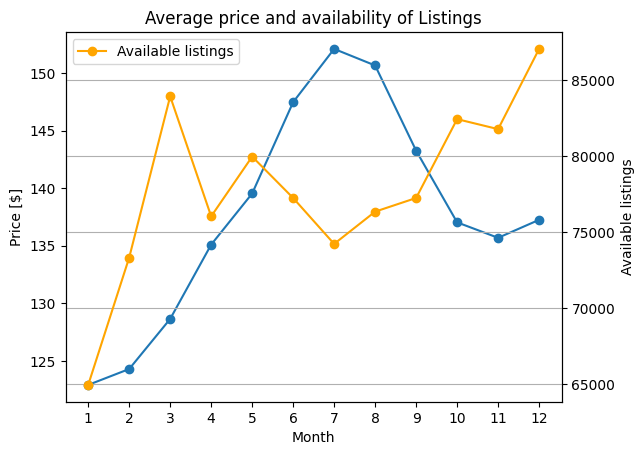

In [10]:
# Plot the prepared data in order to have a visualization which answers the question.
fig, ax = plt.subplots()
ax.plot(range(1,1+len(arr_avg_price_month)), arr_avg_price_month, label='Average price', marker='o')

ax.set_xlabel('Month')
ax.set_xticks(range(1,1+len(arr_avg_price_month)))
ax.set_ylabel('Price [$]')

ax2 = ax.twinx()
ax2.plot(df_available_listings['month'].value_counts().sort_index(), label='Available listings', marker='o', color='orange')
ax2.set_ylabel('Available listings')

plt.grid()
plt.title('Average price and availability of Listings')
plt.legend()
plt.show()

The blue line in the above showed plot is the average price of available listings in Seattle over the months of the year 2016. In yellow one can see the amount of available listings.
It is clearly visible that especially in the summer months (~ May — September) the price is at its highest with prices over 140$ on average. This can of course be explained due to the fact that in these months the demand for apartments, rooms or full houses is also very high. This can be seen by looking at the yellow curve. Exactly where the highest prices are shown we have the lowest number of available listings, which means that most listings are booked. The price rises starting from January, when people probably start making plans for the summer holidays, and falls when the year is coming to an end.

So, it is clearly visible that there is a dependency between price and time of available listings.

Let's move on to business question Nr. 2. Therefore a visual representation of the beforehand calculated correlation between the listings dataframe and the price of available listings is created.

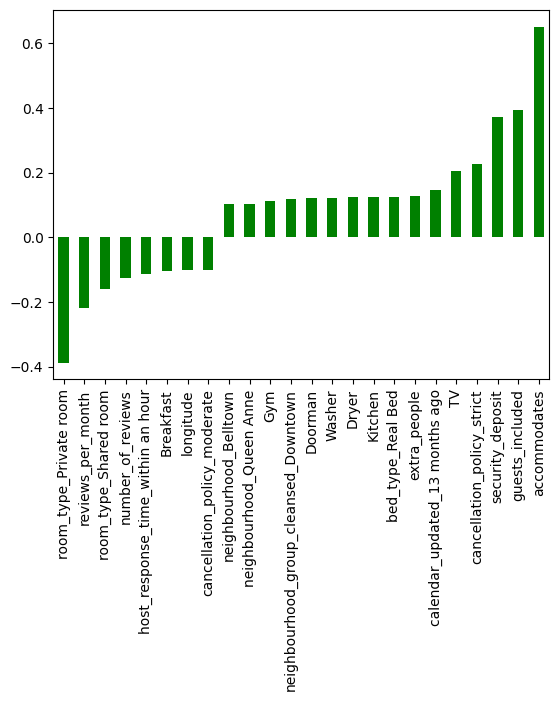

In [11]:
# Plot the correlation results
df_listings.corr()['price'].dropna().sort_values()[:-1].plot(kind='bar', color='green')
plt.show()

On the vertical axis we can see a measure on how much one of the variables is influencing the price. The higher the value, the higher is the influence on the price of a listing. Positive values mean, that these variables influence the price “in the same direction”. So, e.g. there more “guests are included” the higher is the price. Same for the negative values. For example: When the listing is a “private room” the price is lower than for other room types.

So, we can clearly see that there are more variables besides the obvious ones. Especially the quite high influence of "reviews per month" & available "TV" is quite surprising, isn't it? Nevertheless, all of the visible parameters in the plot are used for modeling in the next step since they all have remarkable high impact on the price.

Finally, lets see how our trained model performs. For this we will calculate the r2-score and the mean squared error. We calculate these measures for the training dataset as well as for the test dataset.

In [12]:
# Print model evaluation scores for training and test
print('Training Data:')
print('r-squared score: %.3f' % r2_score(y_train, y_train_pred))
print('mean-squared error: %.3f' % mean_squared_error(y_train, y_train_pred))
print('---')
print('Test Data:')
print('r-squared score: %.3f' % r2_score(y_test, y_test_pred))
print('mean-squared error: %.3f' % mean_squared_error(y_test, y_test_pred))
print('---')

Training Data:
r-squared score: 0.515
mean-squared error: 3860.968
---
Test Data:
r-squared score: 0.468
mean-squared error: 4558.362
---


The R2-Score is with ~ 0.5 ok, but also not a high performer. In my opinion this means, that with the pre-selected information and with the amount of data we had for our training & testing, a linear model can be used to get at least an idea which price tag a new host can pin on his listing. Probably there are better models out there which can reach a higher performance (e.g. random forest). For answering our third business question this result is enough and we can state: Yes, it is possible to predict the price of possible new listings.